In [5]:
from __future__ import annotations

from dataclasses import dataclass
from datetime import datetime, timedelta, timezone
import re
import pandas as pd


In [6]:
@dataclass
class TLERecord:
    name: str
    line1: str
    line2: str
    epoch_utc: datetime
    norad_id: int

def parse_tle_epoch_to_utc(line1: str) -> datetime:
    """
    TLE epoch format in line 1: columns 19-32 -> YYDDD.DDDDDDDD
    YY = year (00-56 -> 2000-2056, 57-99 -> 1957-1999)
    DDD = day of year (1-366)
    fractional part is fraction of the day.
    """
    epoch_str = line1[18:32].strip()  # YYDDD.DDDDDDDD
    yy = int(epoch_str[0:2])
    ddd = int(epoch_str[2:5])
    frac = float("0." + epoch_str.split(".")[1]) if "." in epoch_str else 0.0

    year = 2000 + yy if yy <= 56 else 1900 + yy

    # Jan 1 + (ddd-1) days + fractional day
    dt = datetime(year, 1, 1, tzinfo=timezone.utc) + timedelta(days=ddd - 1) + timedelta(days=frac)
    return dt

def parse_norad_id(line1: str) -> int:
    # line 1: satellite number is columns 3-7
    return int(line1[2:7])

def read_tle_3line_file(path: str) -> list[TLERecord]:
    """
    Reads a common 3-line format: NAME, LINE1 (starts with '1 '), LINE2 (starts with '2 ')
    Returns list of TLERecord.
    """
    records: list[TLERecord] = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.rstrip("\n") for ln in f if ln.strip()]

    i = 0
    while i < len(lines):
        # Expect either NAME then 1/2, or sometimes directly 1/2.
        if lines[i].startswith("1 ") and i + 1 < len(lines) and lines[i + 1].startswith("2 "):
            name = "UNKNOWN"
            line1 = lines[i]
            line2 = lines[i + 1]
            i += 2
        else:
            # NAME line
            name = lines[i].strip()
            if i + 2 >= len(lines):
                break
            line1 = lines[i + 1]
            line2 = lines[i + 2]
            i += 3
            if not (line1.startswith("1 ") and line2.startswith("2 ")):
                continue

        epoch = parse_tle_epoch_to_utc(line1)
        norad = parse_norad_id(line1)
        records.append(TLERecord(name=name, line1=line1, line2=line2, epoch_utc=epoch, norad_id=norad))

    return records


In [7]:
tle_path = "../data/raw/iss_tle.txt"  # Codespaces path (repo-relative)
records = read_tle_3line_file(tle_path)

len(records), records[0]


(32,
 TLERecord(name='ISS (ZARYA)', line1='1 25544U 98067A   26008.50004492  .00009772  00000+0  18407-3 0  9997', line2='2 25544  51.6332   9.9851 0007637 355.2000   4.8914 15.49175445547009', epoch_utc=datetime.datetime(2026, 1, 8, 12, 0, 3, 881088, tzinfo=datetime.timezone.utc), norad_id=25544))

In [8]:
def looks_like_iss(name: str) -> bool:
    n = name.upper()
    return ("ISS" in n) or ("ZARYA" in n) or ("SPACE STATION" in n)

iss_records = [r for r in records if looks_like_iss(r.name)]
len(iss_records), (iss_records[0].name if iss_records else None)



(2, 'ISS (ZARYA)')

In [9]:
def parse_line2_elements(line2: str) -> dict:
    """
    Line 2 common fields (fixed columns):
    - Inclination (deg) cols 9-16
    - RAAN (deg) cols 18-25
    - Eccentricity (decimal point assumed) cols 27-33
    - Argument of perigee (deg) cols 35-42
    - Mean anomaly (deg) cols 44-51
    - Mean motion (rev/day) cols 53-63
    """
    inc = float(line2[8:16].strip())
    raan = float(line2[17:25].strip())
    ecc = float("0." + line2[26:33].strip())
    argp = float(line2[34:42].strip())
    M = float(line2[43:51].strip())
    n = float(line2[52:63].strip())
    return {
        "inclination_deg": inc,
        "raan_deg": raan,
        "eccentricity": ecc,
        "argp_deg": argp,
        "mean_anomaly_deg": M,
        "mean_motion_rev_per_day": n,
    }

rows = []
for r in iss_records:
    el = parse_line2_elements(r.line2)
    rows.append({
        "name": r.name,
        "norad_id": r.norad_id,
        "epoch_utc": r.epoch_utc,
        **el
    })

df = pd.DataFrame(rows).sort_values("epoch_utc").reset_index(drop=True)
df.head()


,name,norad_id,epoch_utc,inclination_deg,raan_deg,eccentricity,argp_deg,mean_anomaly_deg,mean_motion_rev_per_day
0,ISS (ZARYA),25544,2026-01-08 12:00:03.881088+00:00,51.6332,9.9851,0.000764,355.2,4.8914,15.491754
1,ISS (NAUKA),49044,2026-01-08 12:00:03.881088+00:00,51.6332,9.9851,0.000764,355.2,4.8914,15.491754


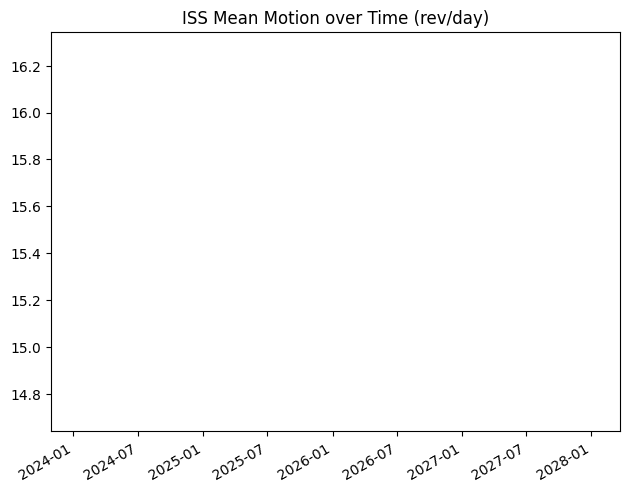

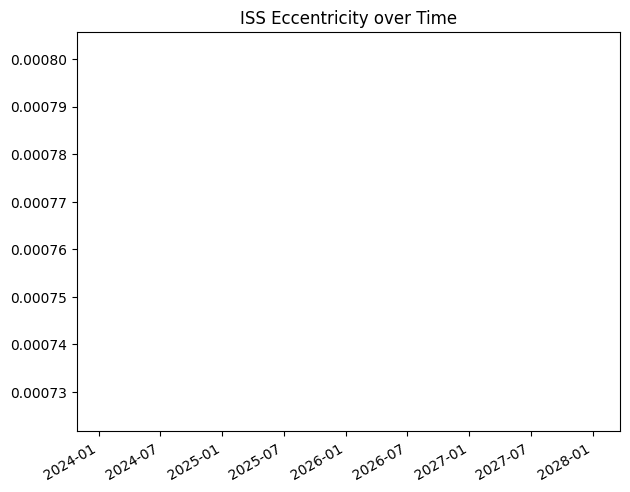

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["epoch_utc"], df["mean_motion_rev_per_day"])
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.title("ISS Mean Motion over Time (rev/day)")
plt.show()

plt.figure()
plt.plot(df["epoch_utc"], df["eccentricity"])
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.title("ISS Eccentricity over Time")
plt.show()


In [12]:
out_path = "../data/processed/iss_tle_elements.csv"
df.to_csv(out_path, index=False)
out_path


'../data/processed/iss_tle_elements.csv'

In [3]:
import requests

url = "https://celestrak.org/NORAD/elements/stations.txt"
response = requests.get(url)

with open("../data/raw/iss_tle.txt", "w") as f:
    f.write(response.text)

print("ISS TLE data downloaded and saved")


ISS TLE data downloaded and saved
